In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
from scipy.stats import binom, norm , poisson, expon , moment

import numba as nb
from numba.experimental import jitclass
from numba.types import float64, int64

In [2]:
@jitclass([('end', float64),
           ('dt', float64),
           ('paths', int64)])
class WeinerGenParameters:
    def __init__(self, end, dt, paths):
        self.end = end
        self.dt = dt
        self.paths = paths
        
    def steps(self):
        return int64(self.end / self.dt)

@nb.njit(parallel = True)
def wiener(wp):
    steps = wp.steps() + 1
    arr = np.zeros((steps, wp.paths))
    for n in nb.prange(wp.paths):
        for i in range(0, steps):
            arr[i + 1, n] = arr[i, n] + np.random.normal(loc = 0, scale = (wp.dt) ** .5)
    return arr 

In [3]:
@nb.njit(parallel = True)
def integrate_ito(wiener_increment):
    n = len(wiener_increment[:,0]) - 1
    k = np.empty(shape =(n,1))
    for i in nb.prange(n):
        k[i] = wiener_increment[i,0]  * (wiener_increment[(i + 1), 0] - wiener_increment[i, 0])
    return k

@nb.njit(parallel = True)
def integrate_stratonovich(wiener_increment):
    n = len(wiener_increment[:,0])
    k = np.zeros(shape =(n,1))
    for i in nb.prange(1,n):
        k[i] = ((wiener_increment[(i-1), 0] + wiener_increment[i, 0]) / 2
                * (wiener_increment[(i+1), 0] - wiener_increment[i, 0]))
    return k

@nb.njit(parallel = True)
def quad_variation(wiener_increment):
    n = len(wiener_increment) - 1
    k = np.empty(shape =(n,1))
    for i in nb.prange(n):
        k[i] =  (wiener_increment[i+1] - wiener_increment[i]) ** 2
    return k

In [4]:
# wp_1_compar = WeinerGenParameters(end = 1., dt = .0001, paths = 100)   
# arr_1_compar = wiener(wp_1_compar)

In [5]:
wp_1 = WeinerGenParameters(end = 1., dt = .0000001, paths = 1)   
wp_5 = WeinerGenParameters(end = 5., dt = .0000005, paths = 1)   
wp_10 = WeinerGenParameters(end = 10., dt = .000001, paths = 1)   

arr_1 = wiener(wp_1)
arr_5 = wiener(wp_5)
arr_10 = wiener(wp_10)

# Ito integral

In [6]:
print(f'''t = {wp_1.end}\nIto approximation: {integrate_ito(arr_1).sum()}\nIto theoretical value: {arr_1[-1][0] ** 2 / 2 - wp_1.end / 2}\n-----------------------''')
print(f'''t = {wp_5.end}\nIto approximation: {integrate_ito(arr_5).sum()}\nIto theoretical value: {arr_5[-1][0] ** 2 / 2 - wp_5.end / 2}\n-----------------------''')
print(f'''t = {wp_10.end}\nIto approximation: {integrate_ito(arr_10).sum()}\nIto theoretical value: {arr_10[-1][0] ** 2 / 2 - wp_10.end / 2}\n-----------------------''')

t = 1.0
Ito approximation: 0.019458517206920732
Ito theoretical value: 0.019446098220668673
-----------------------
t = 5.0
Ito approximation: 2.707452916730632
Ito theoretical value: 2.706450342714753
-----------------------
t = 10.0
Ito approximation: -4.826210807201353
Ito theoretical value: -4.823843269842137
-----------------------


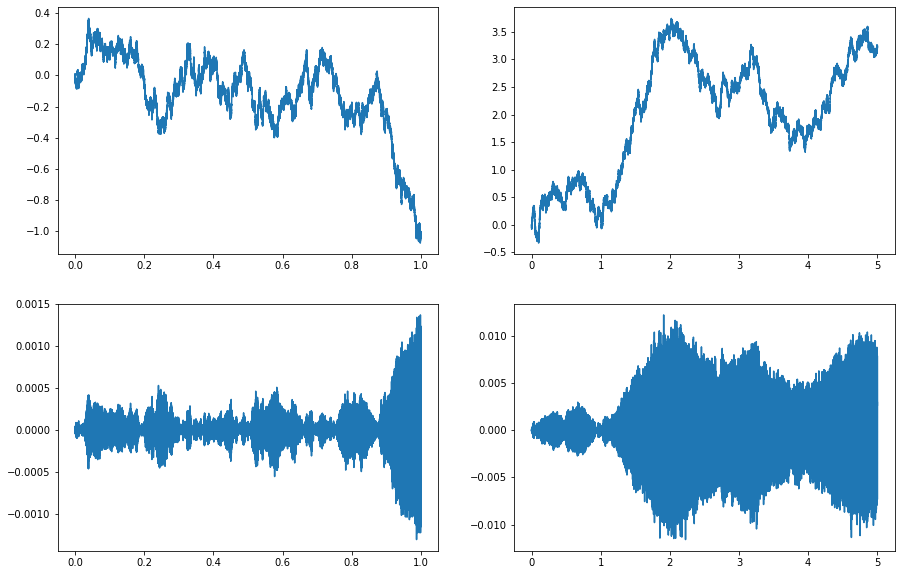

In [7]:
fig = plt.figure(figsize=(15,10))
ax = fig.subplots(nrows=2, ncols=2)
ax[0,0].plot(np.linspace(0, wp_1.end, wp_1.steps() + 1), arr_1)
ax[1,0].plot(np.linspace(0, wp_1.end, wp_1.steps()), integrate_ito(arr_1))

ax[0,1].plot(np.linspace(0, wp_5.end, wp_5.steps() + 1), arr_5)
ax[1,1].plot(np.linspace(0, wp_5.end, wp_5.steps()), integrate_ito(arr_5));

# Stratonovich integral

In [8]:
print(f'''t = {wp_1.end}\nStratonovich approximation: {integrate_stratonovich(arr_1).sum()}\nStratonovich theoretical value: {arr_1[-1][0] ** 2 / 2 - wp_1.end / 2}\n-----------------------''')
print(f'''t = {wp_5.end}\nStratonovich approximation: {integrate_stratonovich(arr_5).sum()}\nStratonovich theoretical value: {arr_5[-1][0] ** 2 / 2 - wp_5.end / 2}\n-----------------------''')
print(f'''t = {wp_10.end}\nStratonovich approximation: {integrate_stratonovich(arr_10).sum()}\nStratonovich theoretical value: {arr_10[-1][0] ** 2 / 2 - wp_10.end / 2}\n-----------------------''')

t = 1.0
Stratonovich approximation: 0.019592125255462473
Stratonovich theoretical value: 0.019446098220668673
-----------------------
t = 5.0
Stratonovich approximation: 2.7051971680360336
Stratonovich theoretical value: 2.706450342714753
-----------------------
t = 10.0
Stratonovich approximation: -4.823090665139364
Stratonovich theoretical value: -4.823843269842137
-----------------------


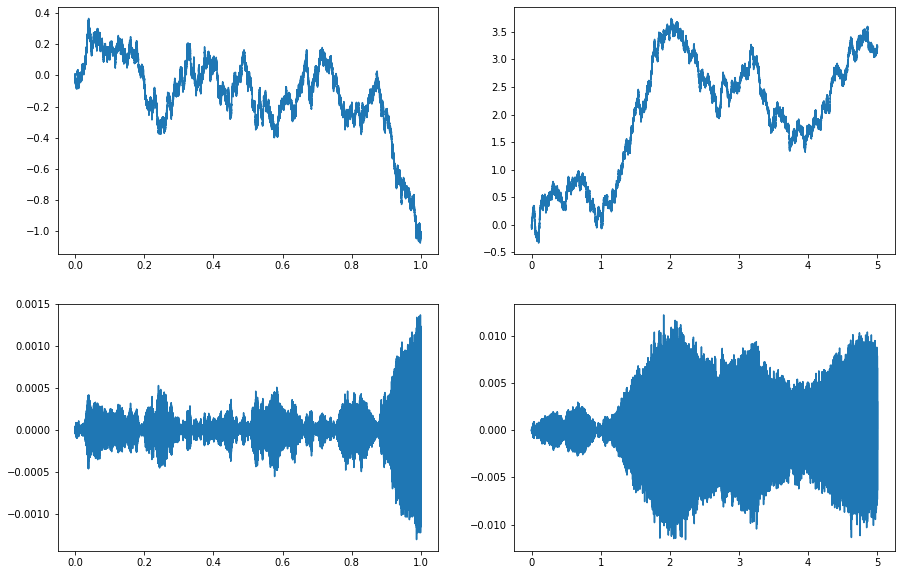

In [9]:
fig = plt.figure(figsize=(15,10))
ax = fig.subplots(nrows=2, ncols=2)
ax[0,0].plot(np.linspace(0, wp_1.end, wp_1.steps() + 1), arr_1)
ax[1,0].plot(np.linspace(0, wp_1.end, wp_1.steps() + 1), integrate_stratonovich(arr_1))

ax[0,1].plot(np.linspace(0, wp_5.end, wp_5.steps() + 1), arr_5)
ax[1,1].plot(np.linspace(0, wp_5.end, wp_5.steps() + 1), integrate_stratonovich(arr_5));

## Is E(X_t ^ 2) == t ^ 2 / 2 

In [18]:
@nb.njit(parallel = True)
def proc_tail(wp, n = 1000):
    steps = wp.steps() + 1
    k = np.empty(shape = n)
    for i in nb.prange(n):
        k[i] = (wiener(wp)[-1][0] ** 2 - wp.end)/2 ** 2
    return k

In [ ]:
expect = proc_tail(wp_1, 100000)

In [22]:
np.mean(expect)

-0.011286768839109403

# Quad variation of X_t = tW_t process convergence to theoretical value

In [ ]:
martl_1 = np.array([arr_1[i][0] * i * wp_1.dt for i in range(wp_1.steps() + 1)])

In [ ]:
print(f'''t = {wp_1.end}\nQuadratic variation approximation: {quad_variation(martl_1).sum()}\nQuadratic variation theoretical value: {wp_1.end ** 3 / 3}\n-----------------------''')